# Running cNMF on myeloid atlas 
* starting with raw data but that has been cleaned (cells removed during iterative cleaning removed from this object and meta transferred)

### Install packages:

``` bash
pip install cnmf
pip install harmonypy
pip install scikit-misc
```

# Following tutorial in package github:

## Set up env:

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
from cnmf import cNMF, Preprocess
import seaborn as sns

In [2]:
#set directory 
os.chdir('/scratch/user/s4436039/scdata/cNMF')

In [3]:
np.random.seed(14)

In [4]:
# load the data
adata = sc.read_h5ad('/scratch/user/s4436039/scdata/Myeloid_Objects/NRclean_Raw_Data.h5ad') #raw cleaned data

In [5]:
print(adata.obs.columns)

Index(['nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type',
       'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major',
       'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'Technology',
       'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H',
       'cancer_broadest', 'patient_treatment'],
      dtype='object')


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


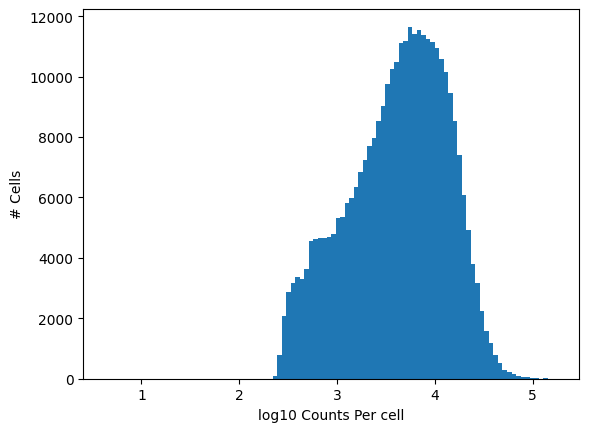

In [6]:
## plot log10 # counts per cell
plt.hist(np.log10(adata.obs['nCount_RNA']), bins=100)
_ = plt.xlabel('log10 Counts Per cell')
_ = plt.ylabel('# Cells')

In [7]:
adata

AnnData object with n_obs × n_vars = 498023 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name'

## Batch correction (run as a batch job):
* tried running in interactive session but includes harmony step which was taking too long

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


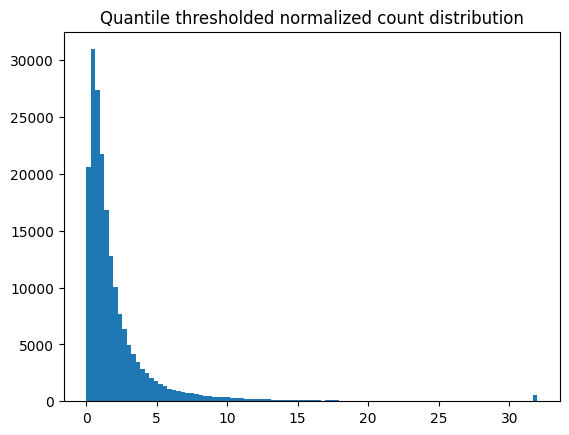

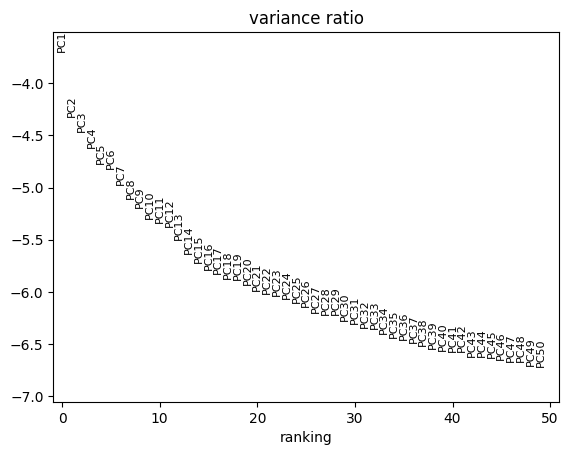

2025-04-29 14:01:38,449 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-29 14:02:43,805 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-29 14:02:47,407 - harmonypy - INFO - Iteration 1 of 20
2025-04-29 14:32:22,070 - harmonypy - INFO - Iteration 2 of 20


KeyboardInterrupt: 

In [ ]:
p = Preprocess(random_seed=14)
(adata_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata, harmony_vars='integration_id', n_top_rna_genes = 2000,
                                                     max_scaled_thresh = None, quantile_thresh = .9999, makeplots=True,
                                                    save_output_base='/scratch/user/s4436039/scdata/cNMF')

### ^ run above as batch job:

### Bashscript: 

``` bash
#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=64
#SBATCH --mem=200G
#SBATCH --job-name=NR-cNMF-1
#SBATCH --time=4:00:00
#SBATCH --partition=general
#SBATCH --account=a_kelvin_tuong
#SBATCH -o NR-cNMF-1.output
#SBATCH -e NR-cNMF-1.error

# export JAVA_CMD=/home/uqztuong/miniforge3/bin/java
source ~/.bashrc
mamba activate env
python3 _NR-script-cNMF-1.py
```

### python:
``` python
import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
from cnmf import cNMF, Preprocess
import seaborn as sns

os.chdir('/scratch/user/s4436039/scdata/cNMF')
np.random.seed(14)

adata = sc.read_h5ad('/scratch/user/s4436039/scdata/Myeloid_Objects/NRclean_Raw_Data.h5ad') #raw cleaned data

p = Preprocess(random_seed=14)
(adata_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata, harmony_vars='integration_id', n_top_rna_genes = 2000,
                                                     max_scaled_thresh = None, quantile_thresh = .9999, makeplots=True,
                                                    save_output_base='/scratch/user/s4436039/scdata/cNMF')
```

#### The corrected data contains only the high-variance genes whereas the TP10K data contains all genes, and the hvgs output is just a list of the highvariance genes. If you specified the save_output_base output, these get saved to the files:
* [save_output_base].Corrected.HVG.Varnorm.h5ad
* [save_output_base].TP10K.h5ad
* [save_output_base].Corrected.HVGs.txt

In [ ]:
adata_c

In [ ]:
hvgs[:5]

In [ ]:
adata_tp10k

## cNMF:

### Now use the batch corrected output files as inputs for cNMF:

In [ ]:
## Results will be saved to [output_directory]/[run_name] 
output_directory = '/scratch/user/s4436039/scdata/cNMF'

In [ ]:
## Initialize the cnmf object that will be used to run analyses
cnmf_obj_corrected = cNMF(output_dir=output_directory, name='BatchCorrected')

In [ ]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
cnmf_obj_corrected.prepare(counts_fn='./example_islets/batchcorrect_example.Corrected.HVG.Varnorm.h5ad',
                           tpm_fn='./example_islets/batchcorrect_example.TP10K.h5ad',
                           genes_file='./example_islets/batchcorrect_example.Corrected.HVGs.txt',
                           components=[15], n_iter=20, seed=14, num_highvar_genes=2000)

In [ ]:
## factorization
cnmf_obj_corrected.factorize(worker_i=0, total_workers=1)

In [ ]:
# combines
cnmf_obj_corrected.combine()

In [ ]:
#compute consensus solution for given choice of k
cnmf_obj_corrected.consensus(k=15, density_threshold=0.1, show_clustering=True, close_clustergram_fig=False)